# RTP Forecasting

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
print(tf.__version__)

2.12.0


In [3]:
cwd = os.getcwd()

In [4]:
def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

In [5]:
#timing callback
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [6]:
# Plot history and future
def plot_predictions(pred , actual, title):
    plt.figure(figsize=(20, 4), dpi=150)
    plt.plot(np.arange(len(pred)), np.array(pred),label='cnn',alpha=0.7)
    plt.plot(np.arange(len(pred)), np.array(actual),label='PF', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', lw=1, alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('Price' , fontsize=18)
    plt.title(title, fontsize=16)

In [7]:
# Plot history and future
def plot_predictions_slide(pred_1,pred_2,pred_3, actual, title):
    plt.figure(figsize=(20, 4), dpi=150)
    plt.plot(np.arange(len(pred_1)), np.array(actual),label='PF', alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_1),label='cnn-24',alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_2),label='cnn-48',alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_3),label='cnn-27',alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', lw=1, alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('Price' , fontsize=18)
    plt.title(title, fontsize=16)

In [8]:
#zones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL',
#         'MHK VL', 'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']
zone = 'N.Y.C.'
year = 2021

### Data Import

In [9]:
# Read each timeseries (RTP = Real-Time Price, DAP = Day-Ahead Price, LF = Load Forecast)
raw_DAP = pd.read_csv("nyiso/da_lmp_zones_df_2015_2021.csv", index_col=0)
raw_RTP = pd.read_csv("nyiso/rt_lmp_zones_df_2015_2021.csv", index_col=0)
raw_LF = pd.read_csv("nyiso/load_frcstd_df_2015_2021.csv", index_col=0)

In [10]:
# Prepare the dataset as a dataframe
raw_data = pd.concat([raw_DAP.loc[:,zone], raw_LF.loc[:,zone], raw_RTP.loc[:,zone]],
                       axis=1).loc['2017-01-01 05:00:00+00:00':]
raw_data.columns = ['DAP', 'LF', 'RTP']
raw_data.index.names = ['date']
raw_data.to_csv('nyiso/NYISO_'+zone+'_raw.csv')

In [11]:
raw_data

,DAP,LF,RTP
date,,,
2017-01-01 05:00:00+00:00,33.60,5065,32.28
2017-01-01 06:00:00+00:00,32.05,4934,30.77
2017-01-01 07:00:00+00:00,29.23,4812,31.17
2017-01-01 08:00:00+00:00,25.02,4728,32.00
2017-01-01 09:00:00+00:00,26.94,4665,27.89
...,...,...,...
2022-01-01 00:00:00+00:00,33.49,5362,30.21
2022-01-01 01:00:00+00:00,31.28,5139,30.23
2022-01-01 02:00:00+00:00,30.49,4943,30.34


In [12]:
# We perform log tranformation before feeding the dataset into the model to make enhance the performance
# We only log tranform the price data (RTP and DAP)
log = 1
# log transformation for the forecasting task log10(Y + 1 - min(Y))
if log:
    log_data = raw_data.copy(deep=True)
    log_data.loc[:,"DAP"] = np.log(raw_data.loc[:,"DAP"] + 1 - min(raw_data.loc[:,"DAP"]))
    log_data.loc[:,"RTP"] = np.log(raw_data.loc[:,"RTP"] + 1 - min(raw_data.loc[:,"RTP"]))
    log_data.to_csv('nyiso/NYISO_'+zone+'_log.csv')

In [13]:
log_data

,DAP,LF,RTP
date,,,
2017-01-01 05:00:00+00:00,3.361417,5065,5.143475
2017-01-01 06:00:00+00:00,3.306154,4934,5.134621
2017-01-01 07:00:00+00:00,3.197039,4812,5.136974
2017-01-01 08:00:00+00:00,3.008155,4728,5.141839
2017-01-01 09:00:00+00:00,3.098740,4665,5.117515
...,...,...,...
2022-01-01 00:00:00+00:00,3.357594,5362,5.131318
2022-01-01 01:00:00+00:00,3.277522,5139,5.131436
2022-01-01 02:00:00+00:00,3.247269,4943,5.132086


### Data Preprocessing

In [14]:
# Split dataset: 2015 year for training and 2016-2017 years for testing
x_train_df = log_data.iloc[:8760*4+24,:]
x_test_df = log_data.iloc[8760*4+24:,:]

y_train_df = log_data.iloc[:8760*4+24,2:]
y_test_df = log_data.iloc[8760*4+24:,2:]

In [15]:
# Standardization
x_mean, x_std = x_train_df.mean(), x_train_df.std()
y_mean, y_std = y_train_df.mean(), y_train_df.std()

x_train = ((x_train_df - x_mean)/x_std).to_numpy()
x_test = ((x_test_df - x_mean)/x_std).to_numpy()

y_train = ((y_train_df - y_mean)/y_std).to_numpy()
y_test = ((y_test_df - y_mean)/y_std).to_numpy()

print(x_train.shape,y_train.shape,x_test.shape, y_test.shape)

(35064, 3) (35064, 1) (8760, 3) (8760, 1)


### Lag = 24

#### Reshape to (samples, steps, features)

In [16]:
n_steps_in = 24
n_steps_out = 24

x_train_cnn = np.array([x_train[i:i+n_steps_in] for i in range(0, x_train.shape[0]-n_steps_in-n_steps_out+1)])
y_train_cnn = np.array([y_train[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train.shape[0]-n_steps_in-n_steps_out+1)])

x_test_cnn = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_cnn = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_cnn.shape,y_train_cnn.shape,x_test_cnn.shape,y_test_cnn.shape)

(35017, 24, 3) (35017, 24, 1) (8713, 24, 3) (8713, 24, 1)


#### Tuned hyperparameters

In [17]:
# set hyperparameters
n_filters  = 32  # number of filters
n_neurons  = 64  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 3
pool_size = 1
learning_rate  = 0.0001
minibatch_size = 32
num_epochs     = 50

#### Building the model

In [18]:
# define model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=n_filters,kernel_size=kernel_size, strides=2, padding='same',
                     input_shape=(x_train_cnn.shape[1],x_train_cnn.shape[2]), activation=activation))
cnn_model.add(Conv1D(filters=n_filters,kernel_size=kernel_size, strides=2, padding='same',
                     input_shape=(x_train_cnn.shape[1],x_train_cnn.shape[2]), activation=activation))
cnn_model.add(MaxPooling1D(pool_size=pool_size))
cnn_model.add(Flatten())
cnn_model.add(Dense(n_neurons, activation=activation))
cnn_model.add(Dense(n_steps_out, activation='linear'))
cnn_model.summary()
cnn_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 32)            320       
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 32)             3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 64)                12352     
                                                                 
 dense_1 (Dense)             (None, 24)                1560      
                                                        

#### Running training

In [19]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = cnn_model.fit(x_train_cnn, y_train_cnn, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


Epoch 1/50
876/876 [==============================] - 2s 2ms/step - loss: 0.9618 - val_loss: 0.2463
Epoch 2/50
876/876 [==============================] - 1s 1ms/step - loss: 0.7089 - val_loss: 0.2122
Epoch 3/50
876/876 [==============================] - 1s 2ms/step - loss: 0.6496 - val_loss: 0.2066
Epoch 4/50
876/876 [==============================] - 1s 2ms/step - loss: 0.6374 - val_loss: 0.2046
Epoch 5/50
876/876 [==============================] - 1s 1ms/step - loss: 0.6285 - val_loss: 0.2030
Epoch 6/50
876/876 [==============================] - 2s 2ms/step - loss: 0.6223 - val_loss: 0.2020
Epoch 7/50
876/876 [==============================] - 2s 2ms/step - loss: 0.6169 - val_loss: 0.2010
Epoch 8/50
876/876 [==============================] - 1s 2ms/step - loss: 0.6123 - val_loss: 0.2003
Epoch 9/50
876/876 [==============================] - 1s 2ms/step - loss: 0.6084 - val_loss: 0.1996
Epoch 10/50
876/876 [==============================] - 2s 2ms/step - loss: 0.6050 - val_loss: 0.1990

#### Saving the model

In [20]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)
cnn_model.save(os.path.join(model_path,'cnn_model_best_24h.h5'))

### Lag = 48

In [21]:
n_steps_in = 48
n_steps_out = 24

x_train_cnn = np.array([x_train[i:i+n_steps_in] for i in range(0, x_train.shape[0]-n_steps_in-n_steps_out+1)])
y_train_cnn = np.array([y_train[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train.shape[0]-n_steps_in-n_steps_out+1)])

x_test_cnn = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_cnn = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_cnn.shape,y_train_cnn.shape,x_test_cnn.shape,y_test_cnn.shape)

# set hyperparameters
n_filters  = 32  # number of filters
n_neurons  = 64  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 3
pool_size = 1
learning_rate  = 0.0001
minibatch_size = 32
num_epochs     = 50

# Building the model
# define model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=n_filters,kernel_size=kernel_size, strides=2, padding='same',
                     input_shape=(x_train_cnn.shape[1],x_train_cnn.shape[2]), activation=activation))
cnn_model.add(Conv1D(filters=n_filters,kernel_size=kernel_size, strides=2, padding='same',
                     input_shape=(x_train_cnn.shape[1],x_train_cnn.shape[2]), activation=activation))
cnn_model.add(MaxPooling1D(pool_size=pool_size))
cnn_model.add(Flatten())
cnn_model.add(Dense(n_neurons, activation=activation))
cnn_model.add(Dense(n_steps_out, activation='linear'))
cnn_model.summary()
cnn_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

cnn_model.summary()

# Running training

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = cnn_model.fit(x_train_cnn, y_train_cnn, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)

# Saving the model
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)
cnn_model.save(os.path.join(model_path,'cnn_model_best_48h.h5'))

(34993, 48, 3) (34993, 24, 1) (8689, 48, 3) (8689, 24, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 24, 32)            320       
                                                                 
 conv1d_3 (Conv1D)           (None, 12, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 32)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                24640     
                                                                 
 dense_3 (Dense)             (None, 24)                1560   

### Lag = 72

In [22]:
n_steps_in = 72
n_steps_out = 24

x_train_cnn = np.array([x_train[i:i+n_steps_in] for i in range(0, x_train.shape[0]-n_steps_in-n_steps_out+1)])
y_train_cnn = np.array([y_train[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train.shape[0]-n_steps_in-n_steps_out+1)])

x_test_cnn = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_cnn = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_cnn.shape,y_train_cnn.shape,x_test_cnn.shape,y_test_cnn.shape)

# set hyperparameters
n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'tanh' # activation function
kernel_size    = 4
pool_size = 2
learning_rate  = 0.001
minibatch_size = 32
num_epochs     = 50

# Building the model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=n_filters,kernel_size=kernel_size, strides=2, padding='same',
                     input_shape=(x_train_cnn.shape[1],x_train_cnn.shape[2]), activation=activation))
cnn_model.add(Conv1D(filters=n_filters,kernel_size=kernel_size, strides=2, padding='same',
                     input_shape=(x_train_cnn.shape[1],x_train_cnn.shape[2]), activation=activation))
cnn_model.add(MaxPooling1D(pool_size=pool_size))
cnn_model.add(Flatten())
cnn_model.add(Dense(n_neurons, activation=activation))
cnn_model.add(Dense(n_steps_out, activation='linear'))
cnn_model.summary()
cnn_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

cnn_model.summary()

# Running training

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = cnn_model.fit(x_train_cnn, y_train_cnn, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)

# Saving the model
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

cnn_model.save(os.path.join(model_path,'cnn_model_best_72h.h5'))

(34969, 72, 3) (34969, 24, 1) (8665, 72, 3) (8665, 24, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 36, 32)            416       
                                                                 
 conv1d_5 (Conv1D)           (None, 18, 32)            4128      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 9, 32)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 288)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                9248      
                                                                 
 dense_5 (Dense)             (None, 24)                792    

### Evaluate

In [23]:
n_steps_in = 24
x_test_cnn = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_cnn_24 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])
cnn_model = load_model(os.path.join(model_path,'cnn_model_best_24h.h5'))
y_test_pred_24 = cnn_model.predict(x_test_cnn)

n_steps_in = 48
x_test_cnn = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_cnn_48 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])
cnn_model = load_model(os.path.join(model_path,'cnn_model_best_48h.h5'))
y_test_pred_48 = cnn_model.predict(x_test_cnn)

n_steps_in = 72
x_test_cnn = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_cnn_72 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])
cnn_model = load_model(os.path.join(model_path,'cnn_model_best_72h.h5'))
y_test_pred_72 = cnn_model.predict(x_test_cnn)


271/271 [==============================] - 0s 1ms/step


In [24]:
# Evaluation metrics
errors = y_test_pred_24 - y_test_cnn_24[:,:,0]
print('24h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_48 - y_test_cnn_48[:,:,0]
print('48h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_72 - y_test_cnn_72[:,:,0]
print('72h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

print('Hour ahead only')
# Evaluation metrics for hour ahead only
errors = y_test_pred_24[:,0] - y_test_cnn_24[:,0,0]
print('24h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_48[:,0] - y_test_cnn_48[:,0,0]
print('48h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_72[:,0] - y_test_cnn_72[:,0,0]
print('72h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

24h
MAE: 0.4017
RMSE: 0.6585

48h
MAE: 0.3958
RMSE: 0.6609

72h
MAE: 0.4302
RMSE: 0.6961

Hour ahead only
24h
MAE: 0.2895
RMSE: 0.5154

48h
MAE: 0.2831
RMSE: 0.5162

72h
MAE: 0.3626
RMSE: 0.5949


### Rescale and evaluate performance

In [25]:
y_test_pred_rescale_24 = y_test_pred_24*y_std.values + y_mean.values
y_test_cnn_rescale_24 = y_test_cnn_24*y_std.values + y_mean.values
y_test_pred_invlog_24 = np.exp(y_test_pred_rescale_24) -1 + min(raw_data.loc[:,"RTP"])
y_test_cnn_invlog_24 = np.exp(y_test_cnn_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_rescale_48 = y_test_pred_48*y_std.values + y_mean.values
y_test_cnn_rescale_48 = y_test_cnn_48*y_std.values + y_mean.values
y_test_pred_invlog_48 = np.exp(y_test_pred_rescale_48) -1 + min(raw_data.loc[:,"RTP"])
y_test_cnn_invlog_48 = np.exp(y_test_cnn_rescale_48) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_rescale_72 = y_test_pred_72*y_std.values + y_mean.values
y_test_cnn_rescale_72 = y_test_cnn_72*y_std.values + y_mean.values
y_test_pred_invlog_72 = np.exp(y_test_pred_rescale_72) -1 + min(raw_data.loc[:,"RTP"])
y_test_cnn_invlog_72 = np.exp(y_test_cnn_rescale_72) -1 + min(raw_data.loc[:,"RTP"])

In [26]:
# Evaluation metrics
# 24 hours ahead
# Evaluation metrics
errors = y_test_pred_invlog_24 - y_test_cnn_invlog_24[:,:,0]
print('24h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_invlog_48 - y_test_cnn_invlog_48[:,:,0]
print('48h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_invlog_72 - y_test_cnn_invlog_72[:,:,0]
print('72h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

print('Hour ahead only')
# Evaluation metrics for hour ahead only
errors = y_test_pred_invlog_24[:,0] - y_test_cnn_invlog_24[:,0,0]
print('24h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_invlog_48[:,0] - y_test_cnn_invlog_48[:,0,0]
print('48h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))
print('')

errors = y_test_pred_invlog_72[:,0] - y_test_cnn_invlog_72[:,0,0]
print('72h')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))


24h
MAE: 10.2440
RMSE: 20.7742

48h
MAE: 10.0895
RMSE: 20.8224

72h
MAE: 10.9328
RMSE: 21.6097

Hour ahead only
24h
MAE: 7.5592
RMSE: 17.1571

48h
MAE: 7.3699
RMSE: 17.2779

72h
MAE: 9.3354
RMSE: 19.1087


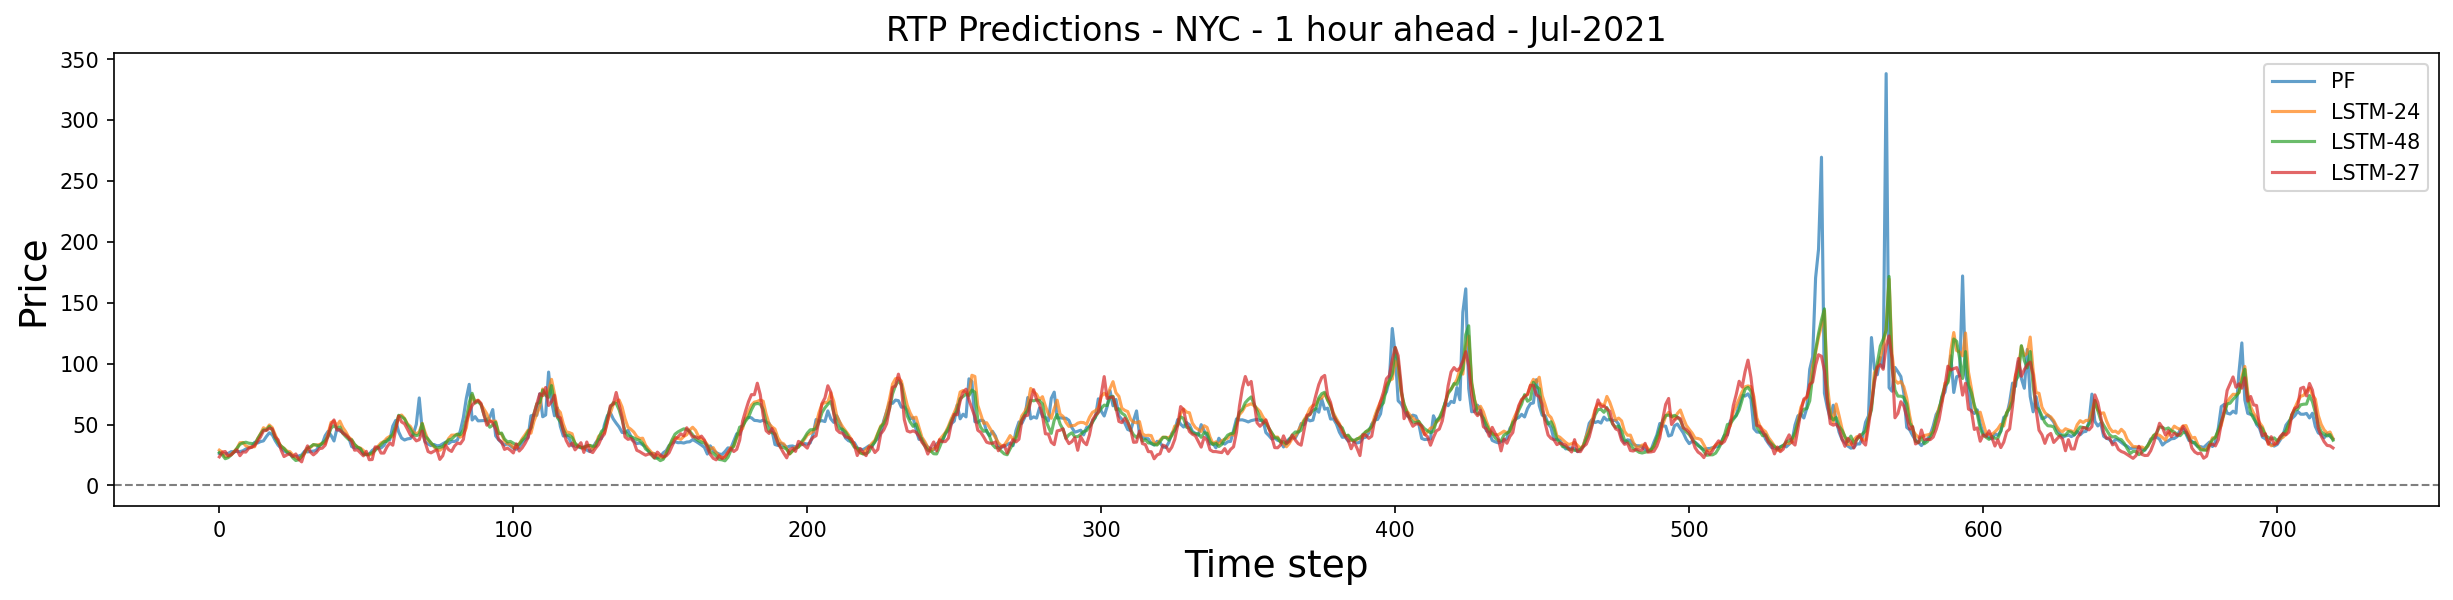

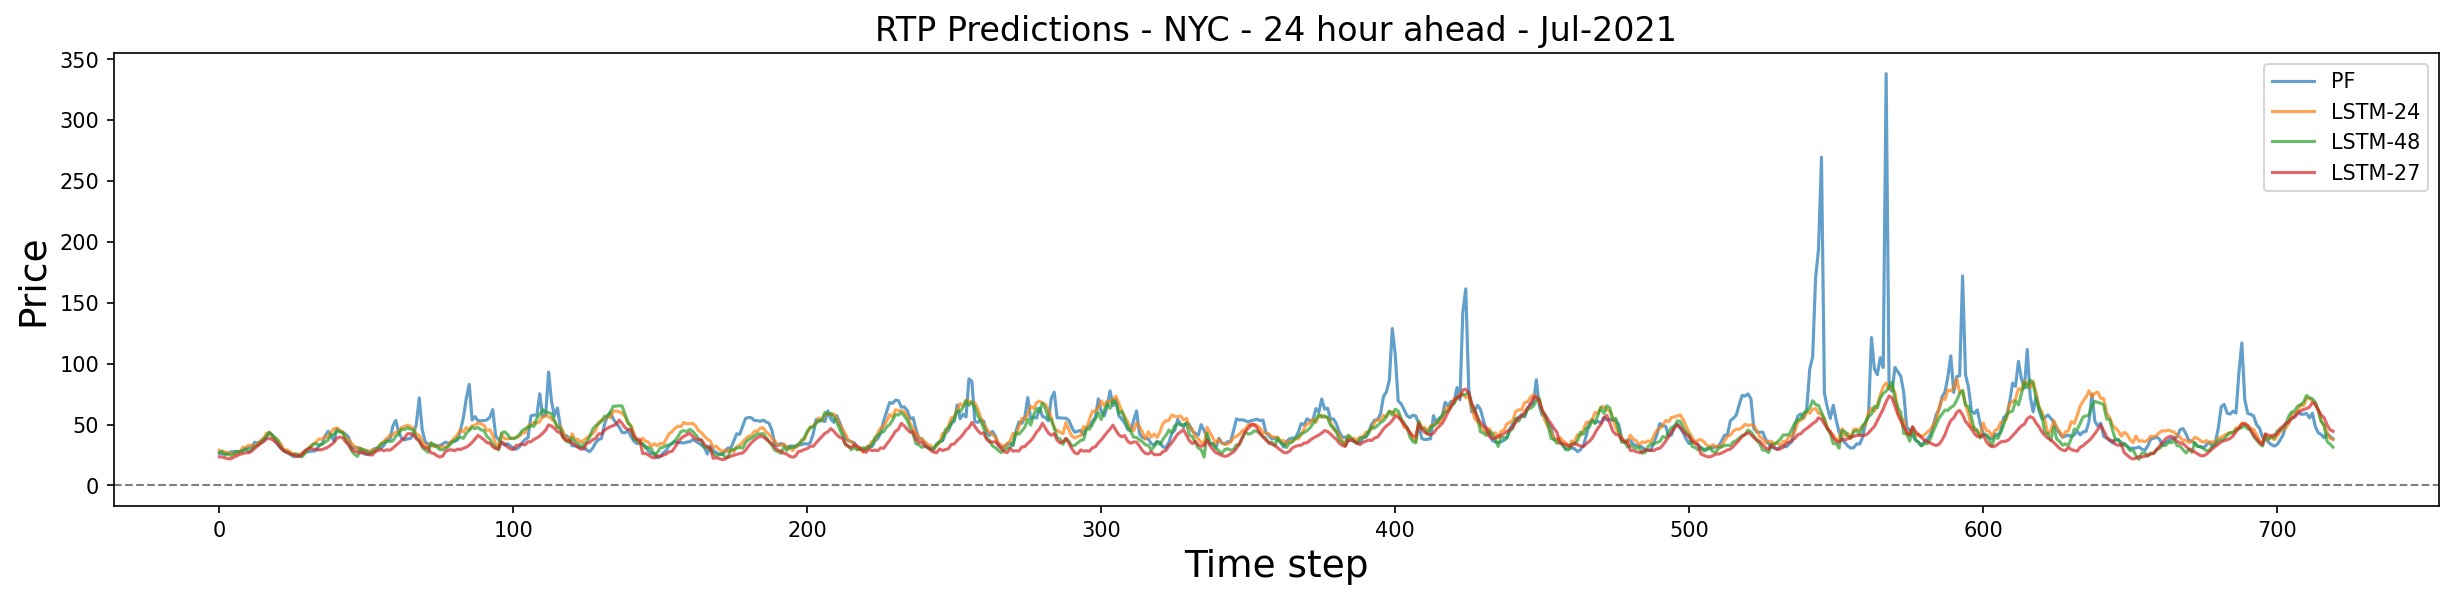

In [28]:
i = 7*24*30
j = i + 24*30

plot_predictions_slide(y_test_pred_invlog_24[i+48:j+48,0].flatten(),
                       y_test_pred_invlog_48[i+24:j+24,0].flatten(),
                       y_test_pred_invlog_72[i:j,0].flatten(),
                       y_test_cnn_invlog_72[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jul-2021')

plot_predictions_slide(y_test_pred_invlog_24[i+48:j+48:24,:].flatten(),
                       y_test_pred_invlog_48[i+24:j+24:24,:].flatten(),
                       y_test_pred_invlog_72[i:j:24,:].flatten(),
                       y_test_cnn_invlog_72[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jul-2021')

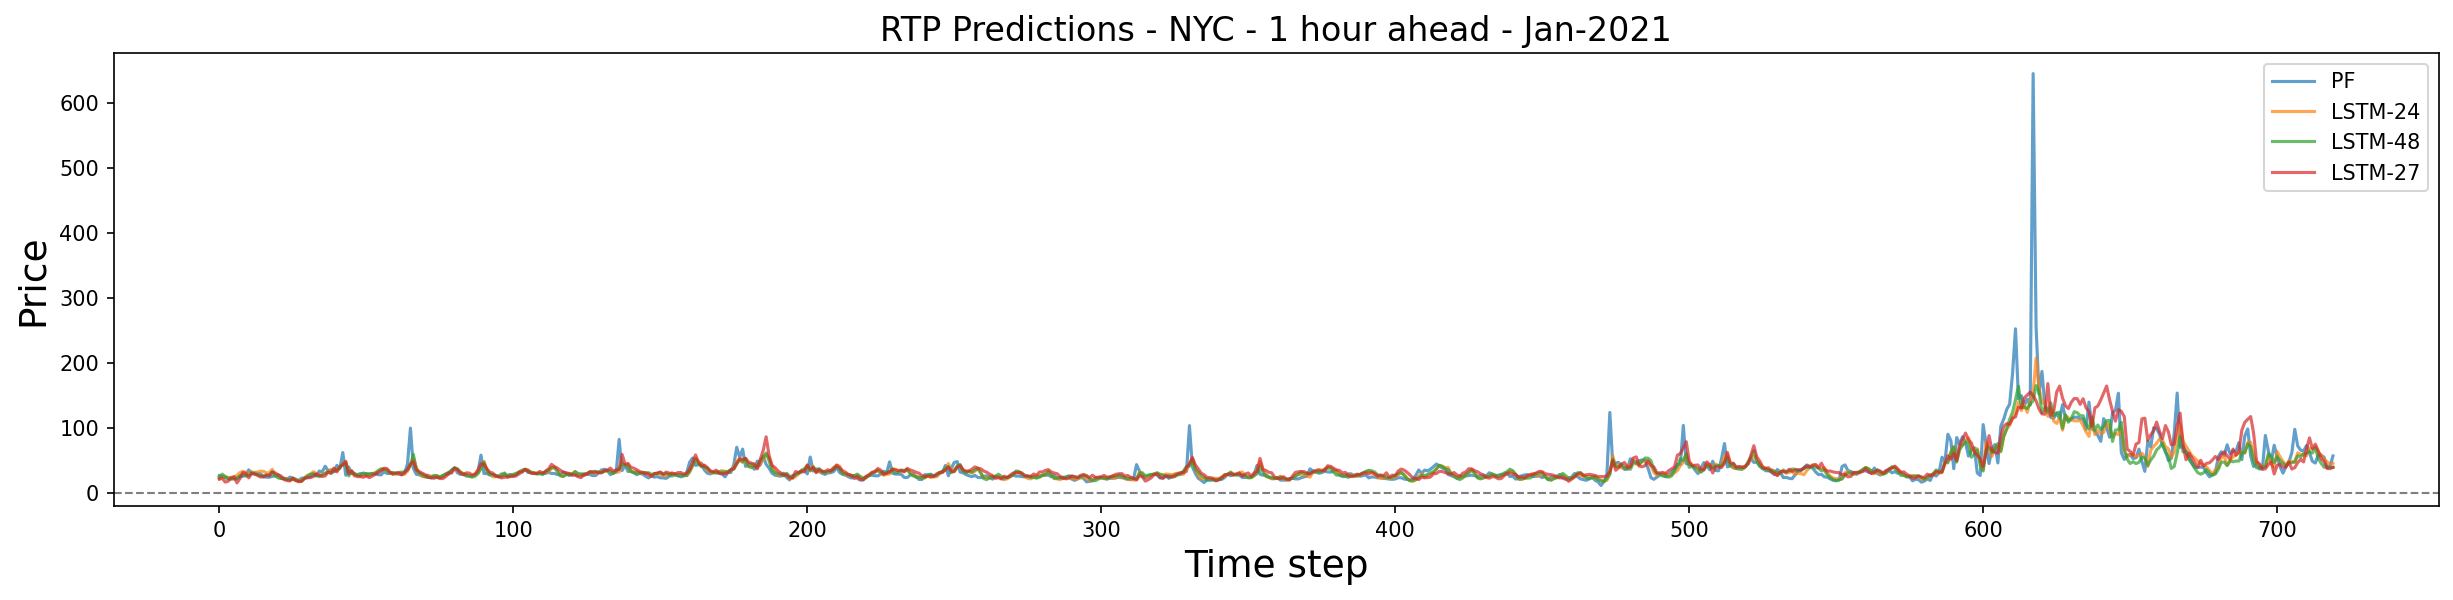

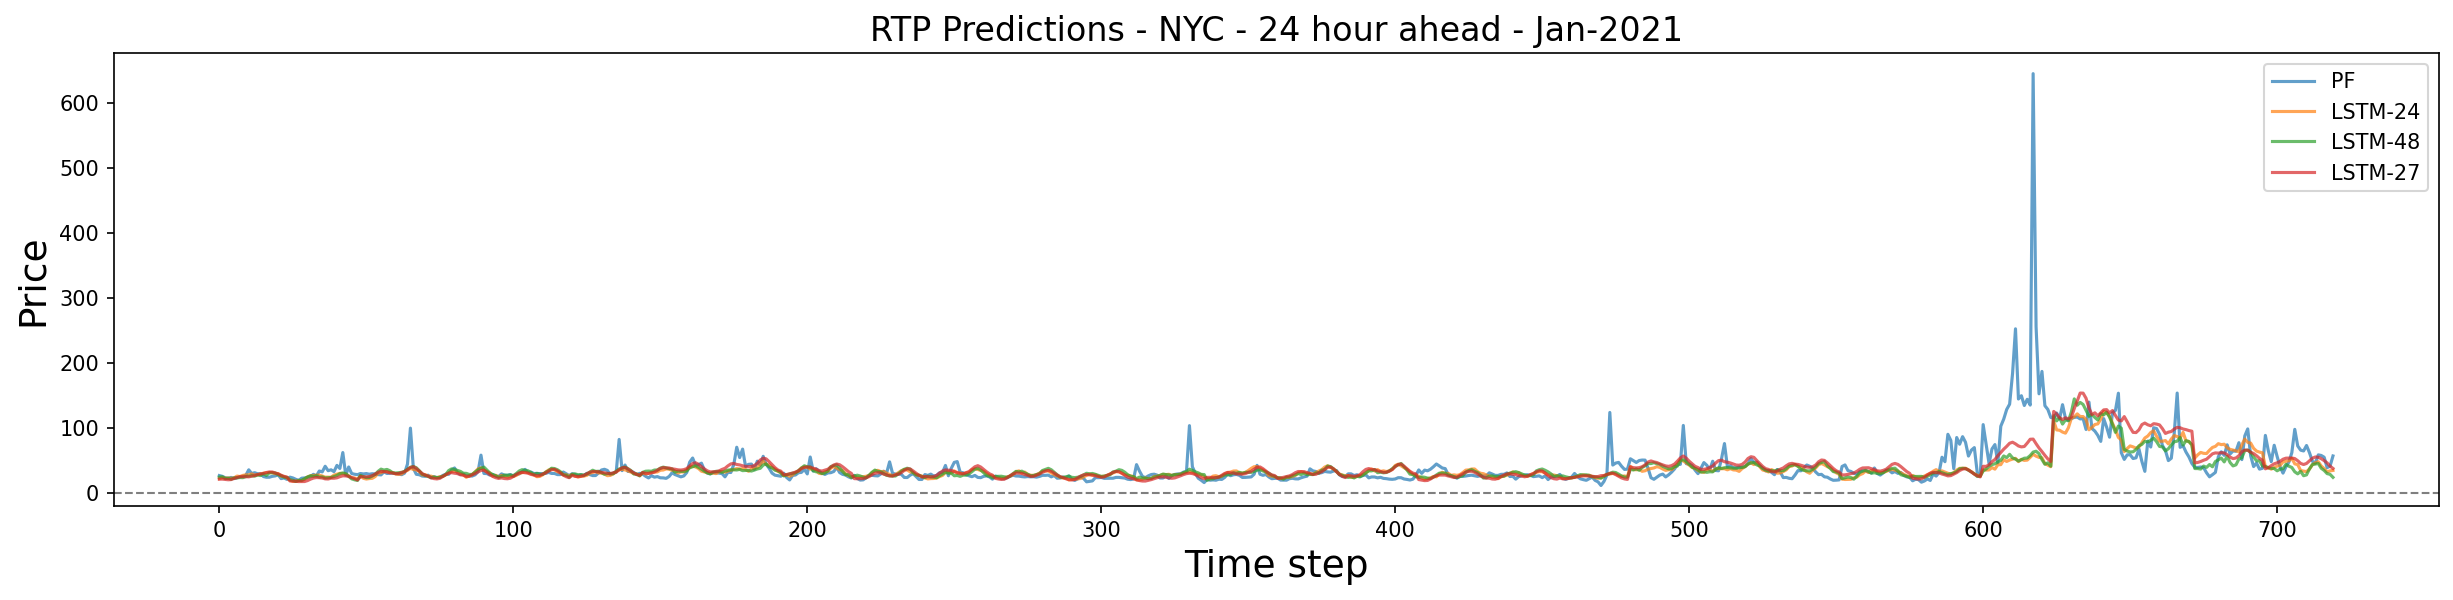

In [29]:
i = 0*24*30
j = i + 24*30

plot_predictions_slide(y_test_pred_invlog_24[i+48:j+48,0].flatten(),
                       y_test_pred_invlog_48[i+24:j+24,0].flatten(),
                       y_test_pred_invlog_72[i:j,0].flatten(),
                       y_test_cnn_invlog_72[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jan-2021')

plot_predictions_slide(y_test_pred_invlog_24[i+48:j+48:24,:].flatten(),
                       y_test_pred_invlog_48[i+24:j+24:24,:].flatten(),
                       y_test_pred_invlog_72[i:j:24,:].flatten(),
                       y_test_cnn_invlog_72[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jan-2021')